In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import get_dataset
from trainer import Trainer
from utils import imshow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import models

def imshow_batch(inp, title=None):
    inp = torchvision.utils.make_grid(inp)
    """Imshow for Tensor."""
    plt.figure(figsize=(14,6))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if title is not None:
        plt.title(title)
    plt.imshow(inp)

# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [4]:
df = pd.read_csv('/opt/ml/input/ext_data//train.csv')
img_path = '/opt/ml/input/data/train/images'

In [21]:
def query1(row):
    if 50 <= row['age'] <=  59 :
        return True
    return False

def query2(row):
    if row['age'] == 60 :
        return True
    return False

In [120]:
from PIL import Image
iterator = df.iterrows()

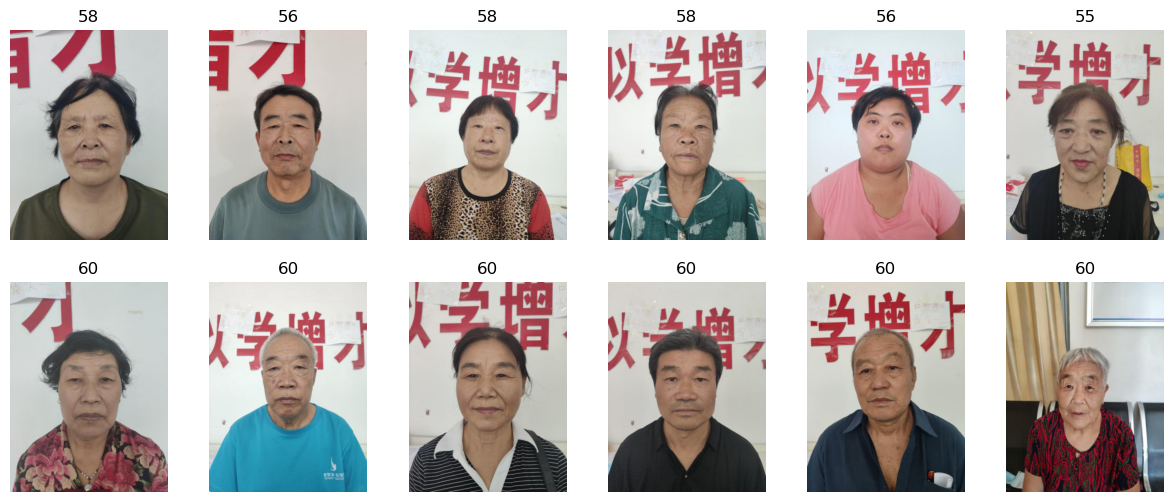

In [122]:
q1, q2 = [], []

while len(q1) < 6 or len(q2) < 6:
    _, row = next(iterator)
    if query1(row):
        q1.append(row)
    if query2(row):
        q2.append(row)

fig, axes = plt.subplots(2, 6, figsize=(15, 6))

for ax in axes.flatten():
    ax.axis('off')

for j, q in enumerate([q1, q2]):
    for i, row in enumerate(q[:6]):
        ax = axes[j][i]
        _img_path = os.path.join(img_path, row.path)
        for f in os.listdir(_img_path):
                if f.startswith('normal'):
                    _img_path = os.path.join(_img_path, f)
                    img = Image.open(_img_path)
                    break
        ax.set_title(row.age)
        ax.imshow(img)

plt.show()

In [9]:
df_train = pd.read_csv('df_train.csv')
df_valid = pd.read_csv('df_valid.csv')
df_test = pd.read_csv('/opt/ml/input/data/eval/info.csv')
train_dataset, valid_dataset, test_dataset = get_dataset(df_train, df_valid, df_test)

In [10]:
## hyperparameters
lr = 0.0003
batch_size = 16
num_epoch = 20

In [34]:
## prepare Dataloader

dataloaders = {'train' : DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True),
               'valid' : DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)}
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)

In [91]:
device = 'cuda'
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model.to(device)
model.load_state_dict(torch.load('/opt/ml/code/save/label/single_8899.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
labels = []

for mask in ['Wear', 'Incorrect', 'Not Wear']:
    for gender in ['Male', 'Female']:
        for age in ['Age < 30', '30 <= Age < 60', '60 <= Age']:
            labels.append(f'Mask:{mask}, Gender:{gender}, {age}')

In [84]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

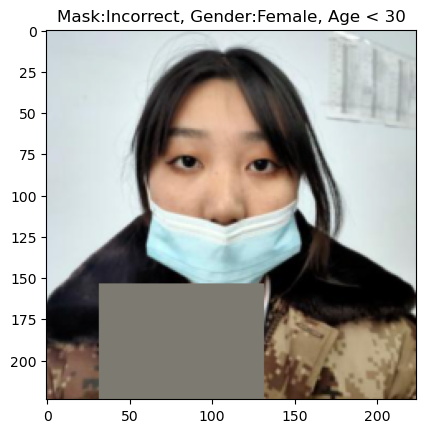

In [161]:
inputs = train_dataset[np.random.randint(0, len(train_dataset)-1)][0].unsqueeze(0)

with torch.no_grad():
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
        
imshow(inputs.squeeze(0).cpu(), title=labels[preds.item()])
plt.show()